# Regression model using regularisation

A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia

The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

The company wants to know:

Which variables are significant in predicting the price of a house, and
How well those variables describe the price of a house.
Also, determine the optimal value of lambda for ridge and lasso regression.

Business Goal 

You are required to model the price of houses with the available independent variables. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for management to understand the pricing dynamics of a new market.

## Step 1: Reading and Understanding the Data

In [308]:
#import sys
#import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,cross_val_score
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics


warnings.filterwarnings('ignore')
%matplotlib inline

In [309]:
housing = pd.read_csv("train.csv")

In [310]:
# Check the head of the dataset
housing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [215]:
#strip spaces if any on columns
housing.columns = housing.columns.str.strip()


In [216]:
#Check the data types of each column and if any column has null value:

housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [217]:
#Check the data types of each column and if any column has null value:
housing.isna().sum()


Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [218]:
round(housing.isnull().sum()/len(housing.index),2).sort_values(ascending=False).head(20)


PoolQC          1.00
MiscFeature     0.96
Alley           0.94
Fence           0.81
FireplaceQu     0.47
LotFrontage     0.18
GarageYrBlt     0.06
GarageFinish    0.06
GarageType      0.06
GarageQual      0.06
GarageCond      0.06
BsmtExposure    0.03
BsmtQual        0.03
BsmtCond        0.03
BsmtFinType2    0.03
BsmtFinType1    0.03
MasVnrType      0.01
MasVnrArea      0.01
Id              0.00
Functional      0.00
dtype: float64

In [219]:
#drop  columns which has > 10% of null values and also ID column which has no importance

In [220]:
housing = housing.drop(['PoolQC','MiscFeature','LotFrontage','Alley','Fence','FireplaceQu'],axis='columns')
housing =housing.drop(['Id'],axis='columns')

In [221]:
housing.describe()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## EDA

In [222]:
#Deal with Year columns. Max Year is 2010, min year is 1872.  
#Considering Max year 2010 as basis and derive new columns by using the max value
    #YearBuilt,YearRemodAdd,GarageYrBlt,YrSold are teh columns


In [223]:
housing['YearBuilt_new'] = housing.YearBuilt.max()-housing.YearBuilt
housing['YearRemodAdd_new'] = housing.YearRemodAdd.max()-housing.YearRemodAdd
housing['GarageYrBlt_new'] = housing.GarageYrBlt.max()-housing.GarageYrBlt
housing['YrSold_new'] = housing.YrSold.max()-housing.YrSold

In [224]:
housing[['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold','YearBuilt_new','YearRemodAdd_new',
             'GarageYrBlt_new','YrSold_new']].sample(10)

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,YearBuilt_new,YearRemodAdd_new,GarageYrBlt_new,YrSold_new
442,1930,1992,1930.0,2008,80,18,80.0,2
838,1995,2006,1999.0,2008,15,4,11.0,2
961,1977,1995,1977.0,2008,33,15,33.0,2
1229,1960,1960,1960.0,2008,50,50,50.0,2
1393,1905,2000,2003.0,2008,105,10,7.0,2
189,2001,2002,2001.0,2008,9,8,9.0,2
363,1972,2007,1972.0,2009,38,3,38.0,1
752,1997,1997,1997.0,2006,13,13,13.0,4
830,1957,1957,1957.0,2008,53,53,53.0,2
42,1983,1983,1983.0,2007,27,27,27.0,3


In [225]:
#drop the old data columns
housing = housing.drop(['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold'],axis='columns')

### Null value Treatment 

NULL Values found for the below columns
GarageYrBlt_new    0.06
GarageFinish       0.06
GarageType         0.06
GarageQual         0.06
GarageCond         0.06
BsmtFinType2       0.03
BsmtFinType1       0.03
BsmtQual           0.03
BsmtCond           0.03
BsmtExposure       0.03
MasVnrType         0.01
MasVnrArea         0.01

In [226]:
housing.GarageYrBlt_new.fillna(-1,inplace=True) #this is based on year
# Filled it with has maximum entries per column
housing.GarageFinish.fillna('Unf',inplace=True) 
housing.GarageType.fillna('Attchd',inplace=True) #
housing.GarageQual.fillna('TA',inplace=True)
housing.GarageCond.fillna('TA',inplace=True)
housing.BsmtFinType2.fillna('Unf',inplace=True)
housing.BsmtFinType1.fillna('Unf',inplace=True)
housing.BsmtQual.fillna('TA',inplace=True)
housing.BsmtCond.fillna('TA',inplace=True)
housing.BsmtExposure.fillna('No',inplace=True)
housing.MasVnrType.fillna('None',inplace=True)
housing.MasVnrArea.fillna(housing.MasVnrArea.mean(),inplace=True)


### Review Numerical Columns

In [227]:
# Select (float and int) variables in the dataset
housing_numeric_columns = housing.select_dtypes(include=['float64', 'int64'])
housing_numeric_columns.head()

,MSSubClass,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice,YearBuilt_new,YearRemodAdd_new,GarageYrBlt_new,YrSold_new
0,60,8450,7,5,196.0,706,0,150,856,856,...,0,0,0,0,2,208500,7,7,7.0,2
1,20,9600,6,8,0.0,978,0,284,1262,1262,...,0,0,0,0,5,181500,34,34,34.0,3
2,60,11250,7,5,162.0,486,0,434,920,920,...,0,0,0,0,9,223500,9,8,9.0,2
3,70,9550,7,5,0.0,216,0,540,756,961,...,0,0,0,0,2,140000,95,40,12.0,4
4,60,14260,8,5,350.0,655,0,490,1145,1145,...,0,0,0,0,12,250000,10,10,10.0,2


In [228]:
#For numerical columns, check the summary statistics:

housing_numeric_columns.describe()

,MSSubClass,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice,YearBuilt_new,YearRemodAdd_new,GarageYrBlt_new,YrSold_new
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,10516.828082,6.099315,5.575342,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,...,3.409589,15.060959,2.758904,43.489041,6.321918,180921.195890,38.732192,25.134247,29.691096,2.184247
std,42.300571,9981.264932,1.382997,1.112799,180.569112,456.098091,161.319273,441.866955,438.705324,386.587738,...,29.317331,55.757415,40.177307,496.123024,2.703626,79442.502883,30.202904,20.645407,25.121824,1.328095
min,20.000000,1300.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,34900.000000,0.000000,0.000000,-1.000000,0.000000
25%,20.000000,7553.500000,5.000000,5.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,...,0.000000,0.000000,0.000000,0.000000,5.000000,129975.000000,10.000000,6.000000,7.000000,1.000000
50%,50.000000,9478.500000,6.000000,5.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,...,0.000000,0.000000,0.000000,0.000000,6.000000,163000.000000,37.000000,16.000000,25.500000,2.000000
75%,70.000000,11601.500000,7.000000,6.000000,164.250000,712.250000,0.000000,808.000000,1298.250000,1391.250000,...,0.000000,0.000000,0.000000,0.000000,8.000000,214000.000000,56.000000,43.000000,48.000000,3.000000
max,190.000000,215245.000000,10.000000,9.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,...,508.000000,480.000000,738.000000,15500.000000,12.000000,755000.000000,138.000000,60.000000,110.000000,4.000000


In [229]:
import math

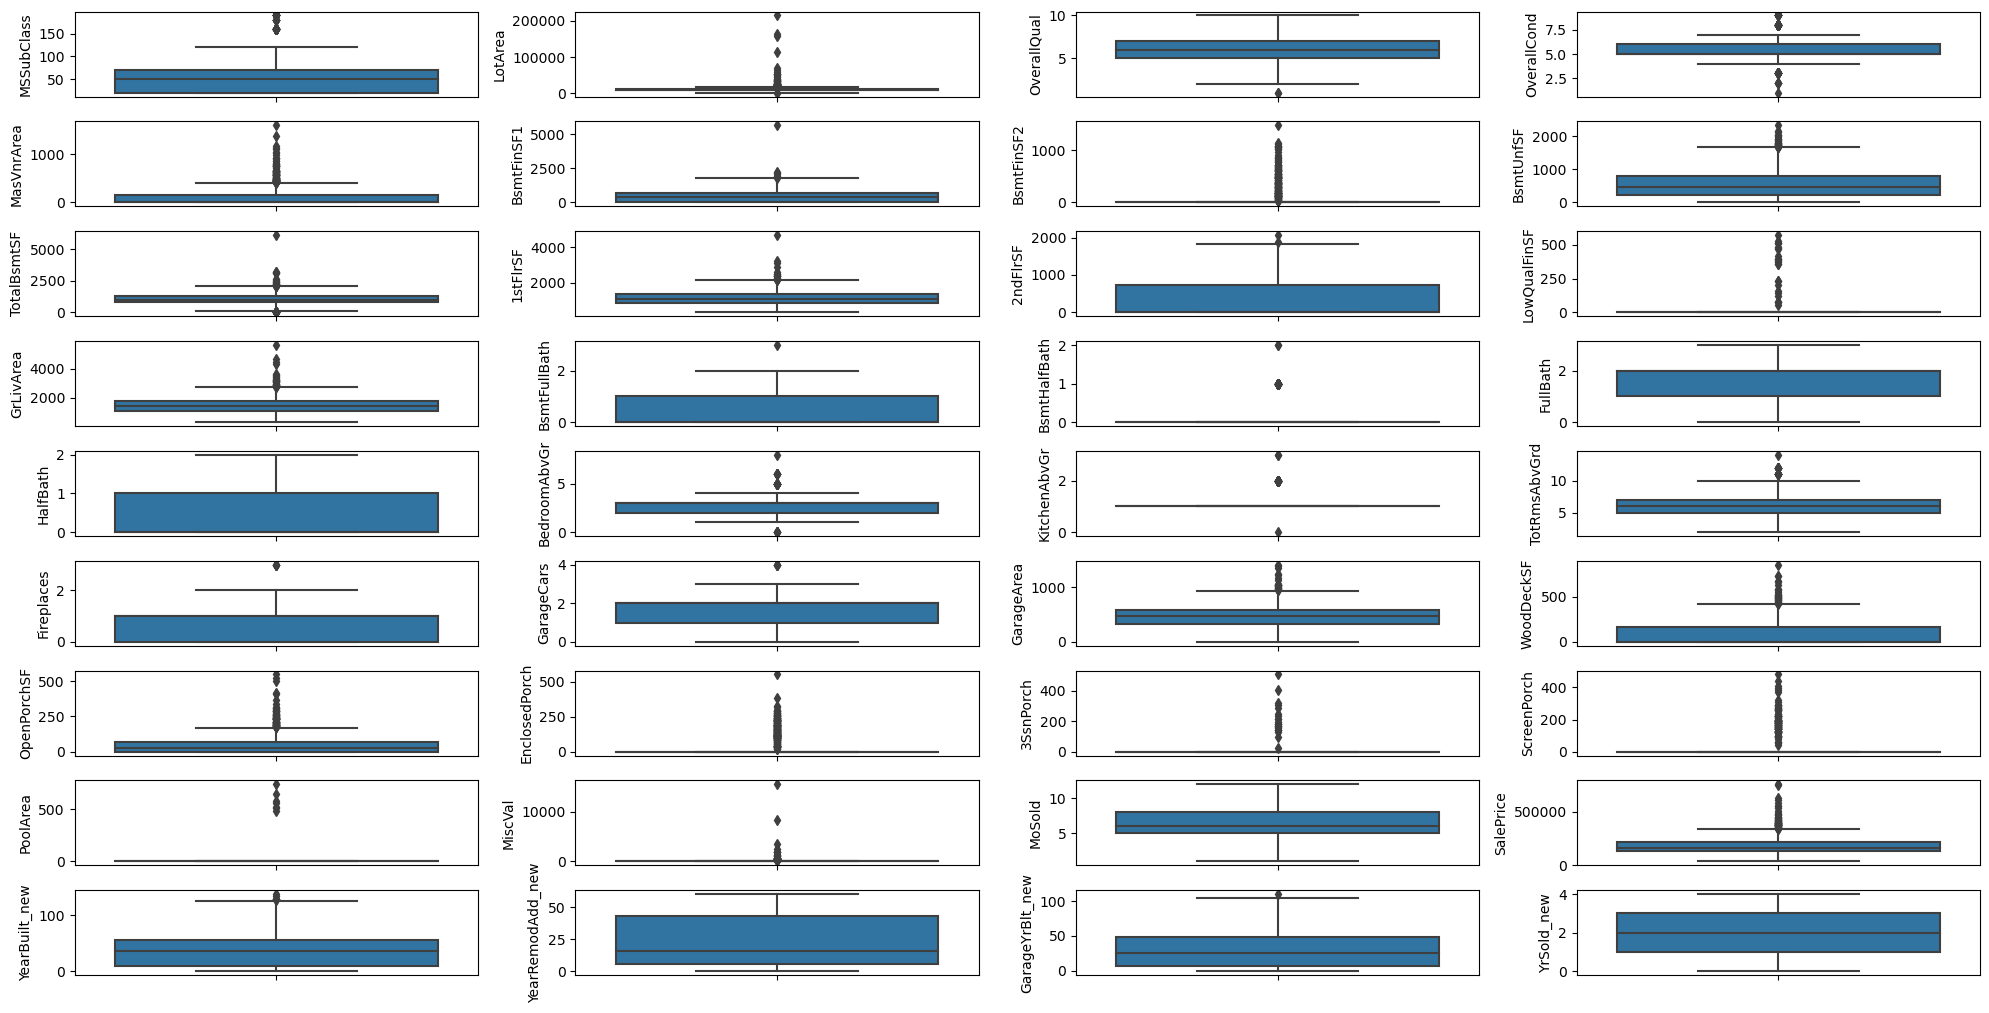

In [230]:
### Handle Outliers
cols = housing_numeric_columns.columns

J = math.ceil(len(cols)/4)
i = 1

plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(J, 4, i)
    sns.boxplot(y=col, data=housing_numeric_columns)
    i += 1
    plt.tight_layout()
plt.show()

In [231]:
housing.shape

(1460, 74)

In [232]:
num_col = list(housing.dtypes[housing.dtypes !='object'].index)
#num_col = ['LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','TotalBsmtSF','1stFlrSF','GrLivArea','OpenPorchSF',
#           'EnclosedPorch','3SsnPorch',
#           'ScreenPorch' ,'PoolArea','MiscVal','SalePrice']
def drop_outliers(x):
    list = []
    for col in num_col:
        Q1 = x[col].quantile(.25)
        Q3 = x[col].quantile(.99)
        IQR = Q3-Q1
        x =  x[(x[col] >= (Q1-(1.5*IQR))) & (x[col] <= (Q3+(1.5*IQR)))] 
    return x   

housing = drop_outliers(housing)

In [233]:
housing.shape

(1440, 74)

In [234]:
# converted columns based on data_description

In [235]:
housing['LandSlope'] = housing.LandSlope.map({'Gtl':0,'Mod':1,'Sev':2})
housing['ExterQual'] = housing.ExterQual.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
housing['BsmtQual'] = housing.BsmtQual.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
housing['BsmtCond'] = housing.BsmtCond.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
housing['BsmtExposure'] = housing.BsmtExposure.map({'NA':0,'No':1,'Mn':2,'Av':3,'Gd':4})
housing['BsmtFinType1'] = housing.BsmtFinType1.map({'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
housing['BsmtFinType2'] = housing.BsmtFinType2.map({'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
housing['HeatingQC'] = housing.HeatingQC.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
housing['CentralAir'] = housing.CentralAir.map({'N':0,'Y':1})
housing['KitchenQual'] = housing.KitchenQual.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
housing['GarageFinish'] = housing.GarageFinish.map({'NA':0,'Unf':1,'RFn':2,'Fin':3})
housing['GarageQual'] = housing.GarageQual.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
housing['GarageCond'] = housing.GarageCond.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
housing['ExterCond'] = housing.ExterCond.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
housing['LotShape'] = housing.LotShape.map({'IR3':0,'IR2':1,'IR1':2,'Reg':3})

In [236]:
#Creating and joining dummy column with the actual dataset


In [237]:
dummy_col = pd.get_dummies(housing[['MSZoning','LandContour','LotConfig','Neighborhood','Condition1','Condition2','BldgType',
             'HouseStyle','RoofStyle','RoofMatl','Exterior1st',  'Exterior2nd','MasVnrType','Foundation',
             'Heating','Electrical','Functional','GarageType','PavedDrive','SaleType','SaleCondition']],
                           drop_first=True)

housing = pd.concat([housing,dummy_col],axis='columns')

housing = housing.drop(['MSZoning','LandContour','LotConfig','Neighborhood','Condition1','Condition2','BldgType',
             'HouseStyle','RoofStyle','RoofMatl','Exterior1st',  'Exterior2nd','MasVnrType','Foundation',
             'Heating','Electrical','Functional','GarageType','PavedDrive','SaleType','SaleCondition'],axis='columns')

In [238]:
housing.head()

,MSSubClass,LotArea,Street,LotShape,Utilities,LandSlope,OverallQual,OverallCond,MasVnrArea,ExterQual,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,8450,Pave,3,AllPub,0,7,5,196.0,3,...,0,0,0,0,1,0,0,0,1,0
1,20,9600,Pave,3,AllPub,0,6,8,0.0,2,...,0,0,0,0,1,0,0,0,1,0
2,60,11250,Pave,2,AllPub,0,7,5,162.0,3,...,0,0,0,0,1,0,0,0,1,0
3,70,9550,Pave,2,AllPub,0,7,5,0.0,2,...,0,0,0,0,1,0,0,0,0,0
4,60,14260,Pave,2,AllPub,0,8,5,350.0,3,...,0,0,0,0,1,0,0,0,1,0


In [239]:
#street,  utilities 

In [240]:
housing.Street.value_counts()
housing.Utilities.value_counts()
housing = housing.drop(['Street','Utilities'],axis='columns')

In [241]:
housing.head()

,MSSubClass,LotArea,LotShape,LandSlope,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,8450,3,0,7,5,196.0,3,2,4,...,0,0,0,0,1,0,0,0,1,0
1,20,9600,3,0,6,8,0.0,2,2,4,...,0,0,0,0,1,0,0,0,1,0
2,60,11250,2,0,7,5,162.0,3,2,4,...,0,0,0,0,1,0,0,0,1,0
3,70,9550,2,0,7,5,0.0,2,2,3,...,0,0,0,0,1,0,0,0,0,0
4,60,14260,2,0,8,5,350.0,3,2,4,...,0,0,0,0,1,0,0,0,1,0


In [242]:
housing.info() #no string columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1440 entries, 0 to 1459
Columns: 194 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(2), int64(49), uint8(143)
memory usage: 786.1 KB


In [243]:
newHousing = housing.copy() # Copy to retain all columnsb

In [244]:
newHousing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1440 entries, 0 to 1459
Columns: 194 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(2), int64(49), uint8(143)
memory usage: 786.1 KB


# Model Building

In [245]:
housing.shape

(1440, 194)

In [246]:
housing.columns

Index(['MSSubClass', 'LotArea', 'LotShape', 'LandSlope', 'OverallQual',
       'OverallCond', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=194)

In [247]:
housing.describe()

,MSSubClass,LotArea,LotShape,LandSlope,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,...,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000
mean,56.795139,10025.127083,2.597222,0.057639,6.093750,5.571528,103.422557,2.395139,2.081944,3.563889,...,0.003472,0.003472,0.084028,0.002083,0.866667,0.002778,0.006944,0.013889,0.821528,0.086111
std,42.193049,5465.849203,0.572954,0.258579,1.379474,1.110513,179.967478,0.571604,0.348062,0.678326,...,0.058844,0.058844,0.277526,0.045612,0.340053,0.052650,0.083072,0.117071,0.383043,0.280626
min,20.000000,1300.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,7500.000000,2.000000,0.000000,5.000000,5.000000,0.000000,2.000000,2.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,50.000000,9434.500000,3.000000,0.000000,6.000000,5.000000,0.000000,2.000000,2.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,70.000000,11500.000000,3.000000,0.000000,7.000000,6.000000,164.250000,3.000000,2.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,190.000000,70761.000000,3.000000,2.000000,10.000000,9.000000,1600.000000,4.000000,4.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [248]:
# Scaling the data between 0 and 1
scaler = MinMaxScaler()
housing = housing.astype(float)
housing = pd.DataFrame(scaler.fit_transform(housing), columns=housing.columns)

In [249]:
housing.describe()

,MSSubClass,LotArea,LotShape,LandSlope,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,...,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000
mean,0.216442,0.125612,0.865741,0.028819,0.565972,0.571441,0.064639,0.465046,0.520486,0.521296,...,0.003472,0.003472,0.084028,0.002083,0.866667,0.002778,0.006944,0.013889,0.821528,0.086111
std,0.248194,0.078689,0.190985,0.129289,0.153275,0.138814,0.112480,0.190535,0.087015,0.226109,...,0.058844,0.058844,0.277526,0.045612,0.340053,0.052650,0.083072,0.117071,0.383043,0.280626
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.089259,0.666667,0.000000,0.444444,0.500000,0.000000,0.333333,0.500000,0.333333,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.176471,0.117109,1.000000,0.000000,0.555556,0.500000,0.000000,0.333333,0.500000,0.666667,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.294118,0.146845,1.000000,0.000000,0.666667,0.625000,0.102656,0.666667,0.500000,0.666667,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [250]:
#y to contain only target variable
#y=housing.pop('SalePrice')
y = housing['SalePrice']
#X is all remainign variable also our independent variables
X = housing.drop(['SalePrice'], axis=1)

#Train Test split with 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [251]:
y.head()

0    0.241078
1    0.203583
2    0.261908
3    0.145952
4    0.298709
Name: SalePrice, dtype: float64

In [252]:
# Checking shape and size for train and test
print(X_train.shape)
print(X_test.shape)

(1008, 193)
(432, 193)


In [253]:
X.head()

,MSSubClass,LotArea,LotShape,LandSlope,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.235294,0.102935,1.000000,0.0,0.666667,0.500,0.12250,0.666667,0.5,0.666667,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.000000,0.119492,1.000000,0.0,0.555556,0.875,0.00000,0.333333,0.5,0.666667,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.235294,0.143246,0.666667,0.0,0.666667,0.500,0.10125,0.666667,0.5,0.666667,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.294118,0.118772,0.666667,0.0,0.666667,0.500,0.00000,0.333333,0.5,0.333333,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.235294,0.186580,0.666667,0.0,0.777778,0.500,0.21875,0.666667,0.5,0.666667,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [254]:
y.head()

0    0.241078
1    0.203583
2    0.261908
3    0.145952
4    0.298709
Name: SalePrice, dtype: float64

# Build a Model using RFE and Automated approach

In [322]:
# Build a Lienar Regression model using SKLearn for RFE
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [323]:
rfe = RFE(lr, n_features_to_select=50) 
rfe.fit(X_train,y_train)

RFE(estimator=LinearRegression(), n_features_to_select=50)

In [324]:
#Columns selected by RFE and their weights
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('MSSubClass', False, 119),
 ('LotArea', False, 141),
 ('LotShape', False, 127),
 ('LandSlope', True, 1),
 ('OverallQual', True, 1),
 ('OverallCond', False, 74),
 ('MasVnrArea', False, 116),
 ('ExterQual', True, 1),
 ('ExterCond', False, 115),
 ('BsmtQual', False, 17),
 ('BsmtCond', False, 129),
 ('BsmtExposure', False, 41),
 ('BsmtFinType1', False, 87),
 ('BsmtFinSF1', False, 125),
 ('BsmtFinType2', False, 94),
 ('BsmtFinSF2', False, 140),
 ('BsmtUnfSF', False, 139),
 ('TotalBsmtSF', False, 131),
 ('HeatingQC', False, 98),
 ('CentralAir', False, 60),
 ('1stFlrSF', False, 137),
 ('2ndFlrSF', False, 132),
 ('LowQualFinSF', False, 136),
 ('GrLivArea', False, 114),
 ('BsmtFullBath', True, 1),
 ('BsmtHalfBath', False, 12),
 ('FullBath', True, 1),
 ('HalfBath', False, 9),
 ('BedroomAbvGr', False, 69),
 ('KitchenAbvGr', False, 36),
 ('KitchenQual', False, 43),
 ('TotRmsAbvGrd', False, 38),
 ('Fireplaces', False, 54),
 ('GarageFinish', False, 101),
 ('GarageCars', True, 1),
 ('GarageArea', F

Manual elimination

In [325]:
#Function to build a model using statsmodel api - Takes the columns to be selected for model as a parameter
def build_model(cols):
    X_train_sm = sm.add_constant(X_train[cols])
    lm = sm.OLS(y_train, X_train_sm).fit()
    print(lm.summary())
    return lm

In [326]:
#Function to calculate VIFs and print them -Takes the columns for which VIF to be calcualted as a parameter
def get_vif(cols):
    df1 = X_train[cols]
    vif = pd.DataFrame()
    vif['Features'] = df1.columns
    vif['VIF'] = [variance_inflation_factor(df1.values, i) for i in range(df1.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    print(vif.sort_values(by='VIF',ascending=False))

In [327]:
#Print Columns selected by RFE. We will start with these columns for manual elimination
X_train.columns[rfe.support_]

Index(['LandSlope', 'OverallQual', 'ExterQual', 'BsmtFullBath', 'FullBath',
       'GarageCars', 'MSZoning_RH', 'LotConfig_CulDSac', 'LotConfig_FR3',
       'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_StoneBr', 'Neighborhood_Veenker', 'Condition2_PosA',
       'Condition2_PosN', 'BldgType_Twnhs', 'BldgType_TwnhsE',
       'HouseStyle_2.5Unf', 'RoofStyle_Gable', 'RoofStyle_Gambrel',
       'RoofStyle_Hip', 'RoofStyle_Mansard', 'RoofMatl_Membran',
       'RoofMatl_Metal', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShngl',
       'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_CemntBd',
       'Exterior1st_ImStucc', 'Exterior1st_Stone', 'Exterior1st_Stucco',
       'Exterior2nd_BrkFace', 'Exterior2nd_CBlock', 'Exterior2nd_CmentBd',
       'Exterior2nd_Stone', 'Exterior2nd_Stucco', 'Exterior2nd_Wd Shng',
       'Foundation_Wood', 'Heating_Grav', 'Heating_OthW', 'Functional_Maj2',
       'GarageType_Attchd', 'GarageType_Basment', 'GarageType_B

In [328]:
X_train_rfe = X_train[['LandSlope', 'OverallQual', 'ExterQual', 'BsmtFullBath', 'FullBath',
       'GarageCars', 'MSZoning_RH', 'LotConfig_CulDSac', 'LotConfig_FR3',
       'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_StoneBr', 'Neighborhood_Veenker', 'Condition2_PosA',
       'Condition2_PosN', 'BldgType_Twnhs', 'BldgType_TwnhsE',
       'HouseStyle_2.5Unf', 'RoofStyle_Gable', 'RoofStyle_Gambrel',
       'RoofStyle_Hip', 'RoofStyle_Mansard', 'RoofMatl_Membran',
       'RoofMatl_Metal', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShngl',
       'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_CemntBd',
       'Exterior1st_ImStucc', 'Exterior1st_Stone', 'Exterior1st_Stucco',
       'Exterior2nd_BrkFace', 'Exterior2nd_CBlock', 'Exterior2nd_CmentBd',
       'Exterior2nd_Stone', 'Exterior2nd_Stucco', 'Exterior2nd_Wd Shng',
       'Foundation_Wood', 'Heating_Grav', 'Heating_OthW', 'Functional_Maj2',
       'GarageType_Attchd', 'GarageType_Basment', 'GarageType_BuiltIn',
       'GarageType_Detchd', 'SaleType_CWD', 'SaleType_ConLw', 'SaleType_New']]

In [329]:
X_train_rfe.shape


(1008, 50)

In [330]:
X_train = X_train_rfe[X_train_rfe.columns]
X_test =  X_test[X_train.columns]

## Model Building and Evaluation


In [300]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm


In [331]:
# list pf alphas

params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 
                    9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation

folds = 5
ridge_model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
ridge_model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5,
                                   0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0,
                                   6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500,
                                   1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [332]:
# display the mean scores

ridge_cv_results = pd.DataFrame(ridge_model_cv.cv_results_)
ridge_cv_results = ridge_cv_results[ridge_cv_results['param_alpha']<=500]
ridge_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])

,param_alpha,mean_train_score,mean_test_score,rank_test_score
13,2.0,-22412.536701,-23655.773690,1
14,3.0,-22552.073306,-23661.137276,2
15,4.0,-22667.057685,-23676.336726,3
16,5.0,-22762.164424,-23709.427253,4
12,1.0,-22229.540699,-23728.930328,5
11,0.9,-22205.119010,-23740.051946,6
10,0.8,-22179.373305,-23751.625305,7
17,6.0,-22844.817254,-23754.114373,8
9,0.7,-22152.026394,-23771.523499,9
8,0.6,-22123.201236,-23793.804537,10


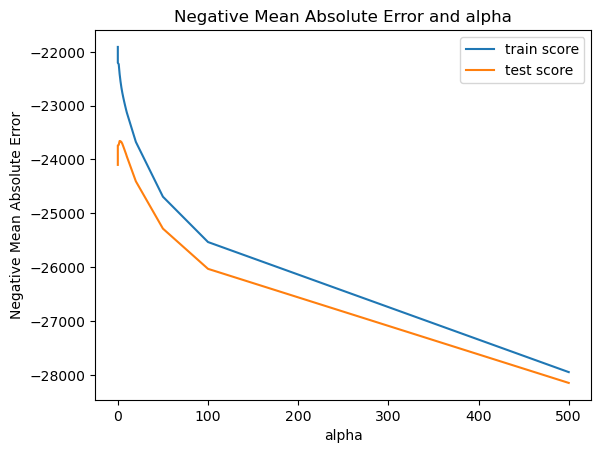

In [333]:
# plotting mean test and train scoes with alpha 

ridge_cv_results['param_alpha'] = ridge_cv_results['param_alpha'].astype('int32')

# plotting

plt.plot(ridge_cv_results['param_alpha'], ridge_cv_results['mean_train_score'])
plt.plot(ridge_cv_results['param_alpha'], ridge_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

In [334]:
# get the best estimator for lambda

ridge_model_cv.best_estimator_

Ridge(alpha=2.0)

In [335]:
# check the coefficient values with lambda = 10

alpha = 10
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
ridge.coef_

array([ 16121.05284357,  22394.42389184,  19614.62133152,  18389.71320535,
        17121.29800102,  17965.15215314,   7452.39817051,  17602.7218437 ,
        -7457.60759356,  31879.91944118,  49400.4899947 ,  36549.86157623,
        22196.91308685,  10325.70452868,   2339.23878578, -18891.16477116,
       -23118.4230503 , -28661.98425985,  -6161.15279832,  -6044.81825219,
         5188.2764544 ,   6069.06789982,   2169.35738483,   -520.68609372,
        -4075.73846719,  -8275.44722944,  48824.1406859 ,  14603.95963384,
         3749.0524455 ,   7872.6147929 ,  -5075.80787456,   5837.23337375,
         5861.18490531,  -5594.25244354,   3749.0524455 ,   -843.37652337,
         1937.38529876,    304.46823459,  -8462.5419512 ,   4698.45504102,
        -6184.32218398,  -4957.60051174,  -7665.61061544,   6107.4665429 ,
         3143.52077013,  15018.01383185,  -2066.30568552,   6014.86083291,
        -3091.38719149,  14540.97703067])

In [336]:
# Check the mean squared error

mean_squared_error(y_test, ridge.predict(X_test))

1187558241.116203

In [337]:
# Put the Features and coefficienst in a dataframe

ridge_df = pd.DataFrame({'Features':X_train.columns, 'Coefficient':ridge.coef_.round(4)})
ridge_df.reset_index(drop=True, inplace=True)
ridge_df

,Features,Coefficient
0,LandSlope,16121.0528
1,OverallQual,22394.4239
2,ExterQual,19614.6213
3,BsmtFullBath,18389.7132
4,FullBath,17121.2980
5,GarageCars,17965.1522
6,MSZoning_RH,7452.3982
7,LotConfig_CulDSac,17602.7218
8,LotConfig_FR3,-7457.6076
9,Neighborhood_Crawfor,31879.9194


# Lasso regression

In [339]:
lasso = Lasso()

# list of alphas

params = {'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.01]}

# cross validation

folds = 5
lasso_model_cv = GridSearchCV(estimator = lasso,                         
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

lasso_model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 11 candidates, totalling 55 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
                                   0.001, 0.002, 0.003, 0.004, 0.005, 0.01]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [340]:
# display the mean scores

lasso_cv_results = pd.DataFrame(lasso_model_cv.cv_results_)
lasso_cv_results[['param_alpha', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by = ['rank_test_score'])

,param_alpha,mean_train_score,mean_test_score,rank_test_score
10,0.01,-21909.294934,-24100.092007,1
9,0.005,-21909.255836,-24100.201478,2
8,0.004,-21909.248015,-24100.223372,3
7,0.003,-21909.240195,-24100.245267,4
6,0.002,-21909.232378,-24100.267162,5
5,0.001,-21909.224562,-24100.289052,6
4,0.0005,-21909.220654,-24100.299997,7
3,0.0004,-21909.219873,-24100.302186,8
2,0.0003,-21909.219091,-24100.304375,9
1,0.0002,-21909.218310,-24100.306564,10


# Ridge Regression

In [341]:
# Applying Ridge Regression with varying the hyperparameter 'lambda'

X_seq = np.linspace(X.min(),X.max(),300).reshape(-1,1) # values to be considered for predictor variable
lambdas = [0, 0.001, 0.01, 0.1, 1, 10, 100, 1000] # Higher the value of lambda, 
                                                  # more the regularization
for i in lambdas: # for each lambda we get different model coefficients
    degree = 5 # Degree for polynomial regression - chose 5 since this is the lowest number that gave a perfect fit
    # Creating degree 5 features
    ridgecoef = PolynomialFeatures(degree)
    # Transforming input features to polynomial features (1, x1, x2, x3, x4, x5)    
    X_poly = ridgecoef.fit_transform(X)
    ridgereg = Ridge(alpha = i) # Initialize the Ridge Regression model with a specific lambda
    ridgereg.fit(X_poly, y) # fit the model on the polynomial features
    
    # Plotting the ridge regression model for each lambda
    plt.figure()
    plt.scatter(X,y)
    plt.plot(X_seq,ridgereg.predict(ridgecoef.fit_transform(X_seq)),color="black") # Polynomial Regression
    plt.plot(X_seq,reg.predict(X_seq),color="red") # Linear Regression
    plt.title("Polynomial regression with degree "+str(degree) + " and lambda = " + str(i))
    plt.show()
    
    #Computing the r2 score
    y_pred = ridgereg.predict(ridgecoef.fit_transform(X))
    print("r2 score = " + str(r2_score(y, y_pred))) 
    print(ridgereg.coef_) # model coefficients

MemoryError: Unable to allocate 25.3 TiB for an array with shape (1440, 2410141734) and data type float64